# Convex Optimization Exercise 4

By Gholamreza Dar

Dr. Amirmazlaghani

Summer 2022

## Imports

In [205]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')

from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.linear_model import LassoCV


from joblib import Parallel, delayed
import multiprocessing

from tqdm import trange

## Functions

In [206]:
def calculate_nu_t(nu_t, ro, X_t, z_t):
    return nu_t + ro*(X_t - z_t)


In [207]:
def calculte_z_t(z_t, X_t, nu_t, ro, lambd):
    e_grad = X_t + nu_t*1.0/ro
    z_t_new = np.zeros_like(z_t)
    l = -(1.0*lambd/ro)*(z_t<0)
    g = (1.0*lambd/ro)*(z_t>0)
    z_t_new = e_grad - l - g
    return z_t_new

In [208]:
def calculte_x_t(X_train, y_train, ro, z_t, nu_t, dim):
    t1 = np.linalg.inv(X_train.T.dot(X_train) + ro * np.identity(dim))
    t2 = X_train.T.dot(y_train) + ro*z_t -  nu_t
    return t1.dot(t2)

In [209]:
def calculate_value(X_train, X_t, y_train, lambd):
    return 0.5*np.linalg.norm(X_train.dot(X_t) - y_train, ord='fro')**2 + lambd*np.linalg.norm(X_t, ord=1)


In [210]:
def calculate_paralell(i,X_train,y_train,nu_t,ro,z_t,X_t):
    ai = X_train[i].reshape(-1,1).T
    bi = y_train[i].reshape(-1,1)
    bi = bi.item()
    nui = nu_t[i].reshape(-1,1)
    term1 = 1/(ai.dot(ai.T) + ro)
    term2 = ai.T*bi + ro*z_t - nui
    term1 = term1.item()
    x = term1*term2
    x = x.T
    X_t[i] = x

In [211]:
def debug_admm(X_train, y_train, X_test, y_test, X_t, iterations=100, lambd=0.01, iteration=0):
    val = calculate_value(X_train, X_t, y_train, lambd)
    train_err = mean_squared_error(X_train.dot(X_t), y_train)
    test_err = mean_squared_error(X_test.dot(X_t), y_test)
    if iteration%10==0:
        print(f"Iteration {iteration}/{iterations} | Value: {round(val, 4)} | train_loss: {train_err.round(8)} | test_loss: {test_err.round(8)}")
    return (train_err, test_err)

In [212]:
def ADMM(X_train, y_train, X_test, y_test, dim=8, iterations=100, lambd=0.01, debug=True):
    # Start with random X and zero z and nu
    ro = 1
    X_t = np.random.randn(dim, 1)
    z_t = np.zeros((dim,1))
    nu_t = np.zeros((dim,1))

    if debug:
        print("Initial Value:", calculate_value(X_train, X_t, y_train, lambd))

    # Loss history
    history = np.zeros((iterations, 2))

    # Update x_t, z_t, nu_t for a many iterations
    for i in trange(iterations):
        X_t = calculte_x_t(X_train, y_train, ro, z_t, nu_t, dim)
        z_t = calculte_z_t(z_t, X_t, nu_t, ro, lambd)
        nu_t = calculate_nu_t(nu_t,ro,X_t,z_t)
        
        if debug:
            train_loss, test_loss = debug_admm(X_train, y_train, X_test, y_test, X_t, iterations=100, lambd=0.01, iteration=i)
            history[i, 0] = train_loss
            history[i, 1] = test_loss
            
    return history


In [213]:
def update_nu_t_paralell(nu_t,X_t,z_t,ro):
    for i in range(nu_t.shape[0]):
        nu_t[i] = (nu_t[i].reshape(-1,1) + ro*(X_t[i].reshape(-1,1) - z_t)).T
    return nu_t

In [214]:
def Parallel_ADMM(X_train, y_train, X_test, y_test, dim=8, iterations=100, lambd=0.01, debug=True):
    # Start with random X and zero z and nu
    ro = 1
    n = X_train.shape[0]
    X_t = np.tile(np.random.randn(dim, 1).T, (n,1))
    z_t = np.zeros((dim,1))
    nu_t = np.tile(np.zeros((dim,1)).T, (n,1))

    X = np.mean(X_t, axis=0).reshape(-1,1)

    # Loss history
    history = np.zeros((iterations, 2))

    for iteration in range(iterations):
        Parallel(n_jobs=multiprocessing.cpu_count() , require='sharedmem')(delayed(calculate_paralell)(i,X_train,y_train,nu_t,ro,z_t,X_t) for i in range(n))

        X = np.mean(X_t, axis=0).reshape(-1,1)
        nu = np.mean(nu_t, axis=0).reshape(-1,1)
        z_t = calculte_z_t(z_t, X, nu, ro, lambd)
        nu_t = update_nu_t_paralell(nu_t,X_t,z_t,ro)
    
        if debug:
            train_loss, test_loss = debug_admm(X_train, y_train, X_test, y_test, X, iterations=100, lambd=0.01, iteration=iteration)
            history[iteration, 0] = train_loss
            history[iteration, 1] = test_loss
    
    return history

In [215]:
def LassoCV_Regresion(X_train, y_train, X_test, y_test):
    model = LassoCV(cv=5, random_state=0).fit(X_train, y_train)

    y_predict_train = model.predict(X_train)
    y_predict_test = model.predict(X_test)
    
    print(f"RMSE Train: {mean_squared_error(y_predict_train, y_train).round(8)}")
    print(f"RMSE Test: {mean_squared_error(y_predict_test, y_test).round(8)}")

## Load Dataset

### Read the csv file

In [216]:
dataset = pd.read_csv("ENB2012_data.csv")
dataset = dataset.sample(frac=1).reset_index(drop=True).to_numpy()

### Normalize the dataset

In [217]:
dataset = preprocessing.normalize(dataset)

### Train Test Split

In [218]:
threshold = int(0.8 * len(dataset))
train_data = dataset[:threshold]
test_data = dataset[threshold:]
X_train, y1_train, y2_train = train_data[:,:8], train_data[:,8].reshape((-1,1)), train_data[:,9].reshape((-1,1))
X_test, y1_test, y2_test = test_data[:,:8], test_data[:,8].reshape((-1,1)), test_data[:,9].reshape((-1,1))

## ADMM ; y_1 

In [219]:
history1 = ADMM(
    X_train, y1_train,
    X_test, y1_test,
    dim=8,
    iterations=100,
    lambd=0.01)

Initial Value: 821.6779411830228


100%|██████████| 100/100 [00:00<00:00, 675.67it/s]

Iteration 0/100 | Value: 0.0247 | train_loss: 7.345e-05 | test_loss: 5.665e-05
Iteration 10/100 | Value: 0.0232 | train_loss: 6.54e-05 | test_loss: 5.013e-05
Iteration 20/100 | Value: 0.0231 | train_loss: 6.514e-05 | test_loss: 4.996e-05
Iteration 30/100 | Value: 0.0232 | train_loss: 6.517e-05 | test_loss: 4.996e-05
Iteration 40/100 | Value: 0.0231 | train_loss: 6.519e-05 | test_loss: 4.998e-05
Iteration 50/100 | Value: 0.0231 | train_loss: 6.529e-05 | test_loss: 5.006e-05
Iteration 60/100 | Value: 0.0232 | train_loss: 6.473e-05 | test_loss: 4.968e-05
Iteration 70/100 | Value: 0.0233 | train_loss: 6.51e-05 | test_loss: 4.992e-05
Iteration 80/100 | Value: 0.0231 | train_loss: 6.55e-05 | test_loss: 5.021e-05
Iteration 90/100 | Value: 0.0232 | train_loss: 6.514e-05 | test_loss: 4.997e-05


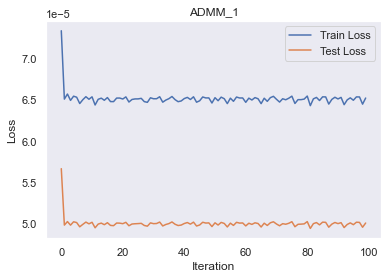

In [220]:
plt.figure()

plt.plot(np.arange(history1.shape[0]), history1[:, 0])
plt.plot(np.arange(history1.shape[0]), history1[:, 1])

plt.title("ADMM_1")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Test Loss"])

plt.show()


## ADMM ; y_2

In [221]:
history2 = ADMM(
    X_train, y2_train,
    X_test, y2_test,
    dim=8,
    iterations=100,
    lambd=0.01)

Initial Value: 211.344327670127


100%|██████████| 100/100 [00:00<00:00, 704.22it/s]

Iteration 0/100 | Value: 0.0247 | train_loss: 7.374e-05 | test_loss: 6.035e-05
Iteration 10/100 | Value: 0.0234 | train_loss: 6.636e-05 | test_loss: 5.401e-05
Iteration 20/100 | Value: 0.0233 | train_loss: 6.614e-05 | test_loss: 5.383e-05
Iteration 30/100 | Value: 0.0233 | train_loss: 6.654e-05 | test_loss: 5.415e-05
Iteration 40/100 | Value: 0.0232 | train_loss: 6.636e-05 | test_loss: 5.401e-05
Iteration 50/100 | Value: 0.0234 | train_loss: 6.577e-05 | test_loss: 5.356e-05
Iteration 60/100 | Value: 0.0233 | train_loss: 6.652e-05 | test_loss: 5.413e-05
Iteration 70/100 | Value: 0.0232 | train_loss: 6.634e-05 | test_loss: 5.399e-05
Iteration 80/100 | Value: 0.0235 | train_loss: 6.53e-05 | test_loss: 5.32e-05
Iteration 90/100 | Value: 0.0234 | train_loss: 6.604e-05 | test_loss: 5.377e-05


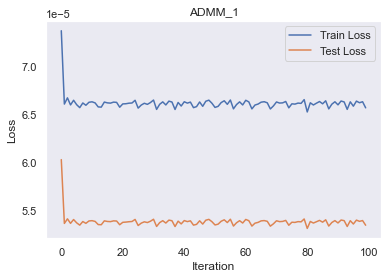

In [222]:
plt.figure()

plt.plot(np.arange(history2.shape[0]), history2[:, 0])
plt.plot(np.arange(history2.shape[0]), history2[:, 1])

plt.title("ADMM_1")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Test Loss"])

plt.show()


## Parallel ADMM ; y_1

In [223]:
history3 = Parallel_ADMM(
    X_train, y1_train,
    X_test, y1_test,
    dim=8,
    iterations=100,
    lambd=0.01)

Iteration 0/100 | Value: 0.1492 | train_loss: 0.00048511 | test_loss: 0.00039608
Iteration 10/100 | Value: 0.1506 | train_loss: 0.00048819 | test_loss: 0.00039863
Iteration 20/100 | Value: 0.1505 | train_loss: 0.00048772 | test_loss: 0.00039823
Iteration 30/100 | Value: 0.1505 | train_loss: 0.00048772 | test_loss: 0.00039823
Iteration 40/100 | Value: 0.1505 | train_loss: 0.00048772 | test_loss: 0.00039823
Iteration 50/100 | Value: 0.1505 | train_loss: 0.00048772 | test_loss: 0.00039823
Iteration 60/100 | Value: 0.1505 | train_loss: 0.00048772 | test_loss: 0.00039823
Iteration 70/100 | Value: 0.1505 | train_loss: 0.00048772 | test_loss: 0.00039823
Iteration 80/100 | Value: 0.1505 | train_loss: 0.00048772 | test_loss: 0.00039823
Iteration 90/100 | Value: 0.1505 | train_loss: 0.00048772 | test_loss: 0.00039823


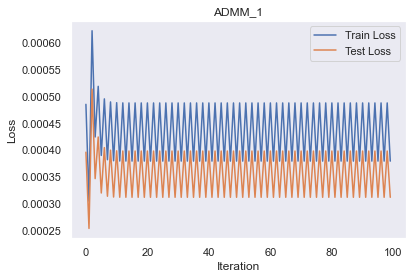

In [224]:
plt.figure()

plt.plot(np.arange(history3.shape[0]), history3[:, 0])
plt.plot(np.arange(history3.shape[0]), history3[:, 1])

plt.title("ADMM_1")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Test Loss"])

plt.show()


## Parallel ADMM ; y_2

In [225]:
history4 = Parallel_ADMM(
    X_train, y2_train,
    X_test, y2_test,
    dim=8,
    iterations=100,
    lambd=0.01)

Iteration 0/100 | Value: 0.1596 | train_loss: 0.00051912 | test_loss: 0.00043145
Iteration 10/100 | Value: 0.1463 | train_loss: 0.0004742 | test_loss: 0.00039299
Iteration 20/100 | Value: 0.1462 | train_loss: 0.00047369 | test_loss: 0.00039255
Iteration 30/100 | Value: 0.1462 | train_loss: 0.00047369 | test_loss: 0.00039255
Iteration 40/100 | Value: 0.1462 | train_loss: 0.00047369 | test_loss: 0.00039255
Iteration 50/100 | Value: 0.1462 | train_loss: 0.00047369 | test_loss: 0.00039255
Iteration 60/100 | Value: 0.1462 | train_loss: 0.00047369 | test_loss: 0.00039255
Iteration 70/100 | Value: 0.1462 | train_loss: 0.00047369 | test_loss: 0.00039255
Iteration 80/100 | Value: 0.1462 | train_loss: 0.00047369 | test_loss: 0.00039255
Iteration 90/100 | Value: 0.1462 | train_loss: 0.00047369 | test_loss: 0.00039255


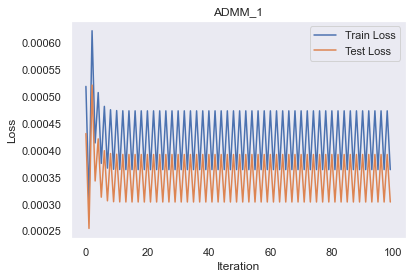

In [226]:
plt.figure()

plt.plot(np.arange(history4.shape[0]), history4[:, 0])
plt.plot(np.arange(history4.shape[0]), history4[:, 1])

plt.title("ADMM_1")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Test Loss"])

plt.show()


## Lasso CV Regression ; y_1

In [227]:
LassoCV_Regresion(X_train, y1_train.ravel(), X_test, y1_test)

RMSE Train: 3.189e-05
RMSE Test: 2.977e-05


## Lasso CV Regression ; y_2

In [228]:
LassoCV_Regresion(X_train, y2_train.ravel(), X_test, y2_test)

RMSE Train: 2.887e-05
RMSE Test: 2.737e-05
